# Comparing Geneformer & TranscriptFormer for cell-type classification

Run this notebook on google colab to use a free GPU! 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Geneformer-vs-TranscriptFormer.ipynb)

One known downstream application of RNA foundation models is cell-type classification. However, it is not always easy to know which foundation model will perform best and working with different bio foundation models is time consuming. With the Helical package, we have streamlined this task and made foundation models interchangaeble.

In the example notebook, we levarge Helical to compare two leading RNA foundation models: Geneformer and TranscriptFormer. We show you how to use these models for classifying cell types and evaluate them on a labelled data set.
It also serves a template on to use those models in a standardised way in your own applications.

### Geneformer
Geneformer is a foundation transformer model pretrained on Genecorpus-30M, a corpus comprised of ~30 million single cell transcriptomes from a broad range of human tissues. Each single cell’s transcriptome is presented to the model as a rank value encoding where genes are ranked by their expression in that cell normalized by their expression across the entire Genecorpus-30M. Geneformer displays both zero-shot capabilities as well as fine-tuning tasks relevant to chromatin and network dynamics.
- 📄 [Paper](https://www.nature.com/articles/s41586-023-06139-9): The paper that made it into Nature!

### TranscriptFormer
TranscriptFormer is a family of generative foundation models representing a cross-species generative cell atlas trained on up to 112 million cells spanning 1.53 billion years of evolution across 12 species.
- 📄 [Paper](https://www.biorxiv.org/content/10.1101/2025.04.25.650731v1)
- 💽 [GitHub](https://github.com/czi-ai/transcriptformer)


### 🧬 About Helical:
Helical provides an open-source framework for and gathers state-of-the-art pre-trained genomics and transciptomics bio foundation models. Still work in progress, but we look forward to interacting with the community to build meaningful things. You can directly reach us:
- support@helical-ai.com (slack-channel incoming). We answer within hours! Reach out if you have questions, ideas, improvement suggestions, colab, ...
- [Github](https://github.com/helicalAI/helical-package/issues). On our github in the issue section 


### Before you start
Be sure to install the Helical python package as descibed in [Installation](https://github.com/helicalAI/helical-package).

## 1) Imports 
Let's start by importing all the packages used in this notebook

In [1]:
# !pip install helical

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd
import numpy as np
import logging
import torch
from helical.utils import get_anndata_from_hf_dataset
from datasets import load_dataset

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

# Import Geneformer & TranscriptFormer from the Helical package
from helical.models.geneformer import Geneformer,GeneformerConfig
from helical.models.transcriptformer import TranscriptFormer, TranscriptFormerConfig


/home/benoit/miniconda3/envs/helical-package/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.6.0 available.


## 2) Dataset loading and Splitting

We first load the human fetal yolk sac scRNA-seq data from the Helical Hugging Face datasets.

The yolk sac (YS) generates the first blood and immune cells and provides nutritional and metabolic support to the developing embryo.

There are three granularity levels of cell annotation you can access in the data.

For example purposes we use the least granular LVL1 cell annotation.

Let's start by running the command below to download the data set automatically (this could take a few seconds):

In [2]:
hf_dataset = load_dataset("helical-ai/yolksac_human", trust_remote_code=True, download_mode="reuse_cache_if_exists")

Generating test split: 100%|██████████| 6336/6336 [00:03<00:00, 1972.58 examples/s]


We split the data in a train and test sets

In [3]:
# Shuffle the dataset.
# Seed used for reproducibility
hf_dataset.shuffle(seed=42)
X_train = get_anndata_from_hf_dataset(hf_dataset["train"])[:1000]
X_test = get_anndata_from_hf_dataset(hf_dataset["test"])[:100]

## 3) Zero Shot prediction with Geneformer

### 3.1) Model training and inference

The first time you execute the cell below, the model weights will be downloaded automatically, this could take a few seconds:

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_config = GeneformerConfig(batch_size=10,device=device)   
geneformer = Geneformer(configurer=model_config)

In [13]:
# The "process_data"-function from the Helical package pre-processes the data. 
# It takes AnnData as an input. 
# More information in our documentation
train_dataset = geneformer.process_data(X_train, gene_names="gene_name")
test_dataset = geneformer.process_data(X_test, gene_names="gene_name")

Map: 100%|██████████| 100/100 [00:00<00:00, 1789.72 examples/s]


In [14]:
ref_embeddings = geneformer.get_embeddings(train_dataset)
test_embeddings = geneformer.get_embeddings(test_dataset)

100%|██████████| 10/10 [00:01<00:00,  6.69it/s]


### 3.2) Visualization with UMAP
Let's visualize the embeddings leveraging UMAP. The idea is simple: can we identify clusters of cells that the models considers as being similar enough to put them close in space ? If this hypothesis happens to be true, the models can be used to infer cell types based on a few hand-labelled cells!

In the cell below, we plot our outputs once without labels and onc with the labels from our dataset (which in a real-world setup would of course not be available).

Text(0.5, 1.0, 'UMAP of Reference Data with labels')

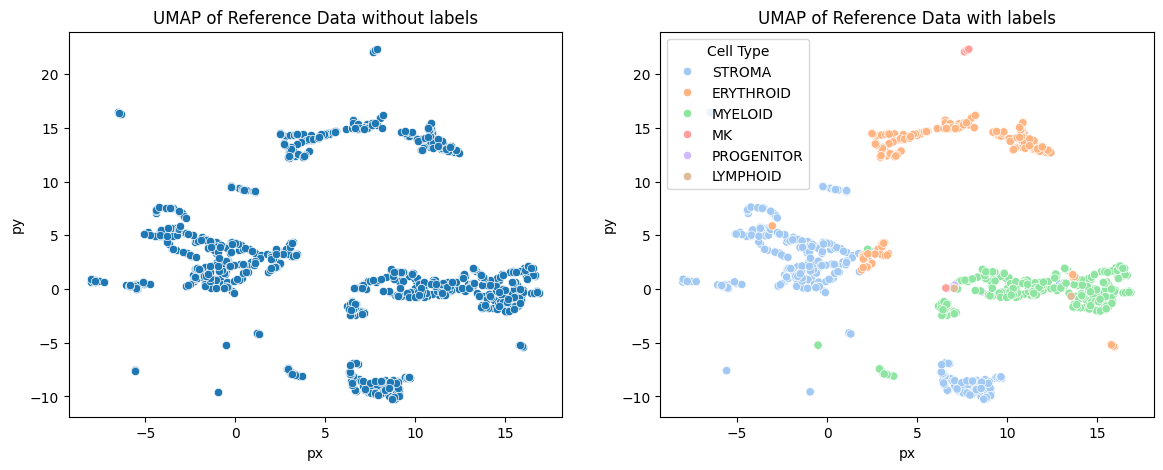

In [15]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None,n_neighbors=3)
mapper = reducer.fit(ref_embeddings)

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
labels = X_train.obs['LVL1']
plot_df['Cell Type'] = labels.values


# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

#plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of Reference Data with labels')

This looks great! Geneformer seems to be capable to cluster cells according to their cell type. Let's explore how we can leverage this capability to infer cell types on an unlabelled data set.

## 4) Prediction: Leverage your hand-labelled cells to predict label of other cells

We can use a K-Neirhbours classifier to predict cell types on an unlabelled data set. We have separated our data set into a train and test set. Let's use the train set to train a classifier and predict labels on the "unseen" test set. We can then use the labels in this test set to evaluate how accurate our prediction was.

In [16]:
labels = X_train.obs['LVL1']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

KNeighborsClassifier(metric='cosine')

In [17]:
pred_labels = neigh.predict(test_embeddings)

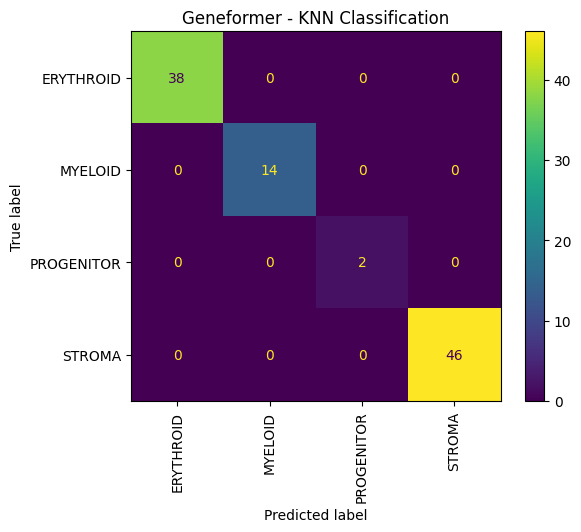

In [18]:
cm_geneformer = confusion_matrix(X_test.obs['LVL1'],pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_geneformer, display_labels=np.unique(np.concatenate((X_test.obs['LVL1'], pred_labels))))
disp.plot(xticks_rotation="vertical")
plt.title("Geneformer - KNN Classification")
plt.show()

In [19]:
print(classification_report(X_test.obs['LVL1'],pred_labels))

              precision    recall  f1-score   support

   ERYTHROID       1.00      1.00      1.00        38
     MYELOID       1.00      1.00      1.00        14
  PROGENITOR       1.00      1.00      1.00         2
      STROMA       1.00      1.00      1.00        46

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



## 4) Zero Shot prediction with TranscriptFormer

Let's do the same with TranscriptFormer so we can compare the performance!

### Model training and inference


In [4]:
model_config = TranscriptFormerConfig()
transcriptformer = TranscriptFormer(configurer=model_config)

In [5]:
train_data = transcriptformer.process_data([X_train]) # transcriptformer expects a list of AnnData objects
ref_embeddings = transcriptformer.get_embeddings(train_data)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 125/125 [00:23<00:00,  5.36it/s]


### Visualization with UMAP

Text(0.5, 1.0, 'UMAP of Reference Data with labels')

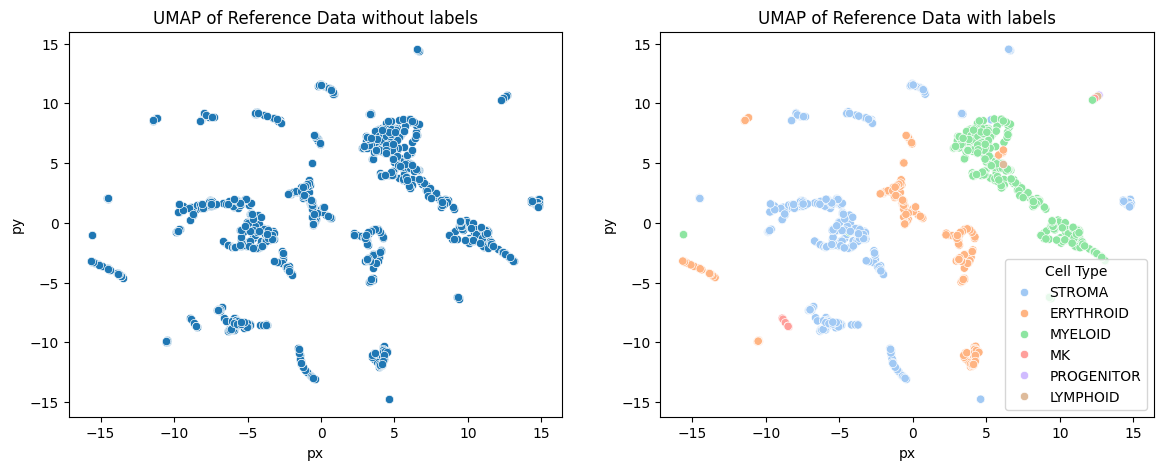

In [6]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None,n_neighbors=3)
mapper = reducer.fit(ref_embeddings)

labels = X_train.obs['LVL1']

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of Reference Data with labels')

### Evaluation: k-nearest neighbors

In [7]:
test_data = transcriptformer.process_data([X_test])
test_embeddings = transcriptformer.get_embeddings(test_data)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


In [8]:
labels = X_train.obs['LVL1']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

pred_labels = neigh.predict(test_embeddings)

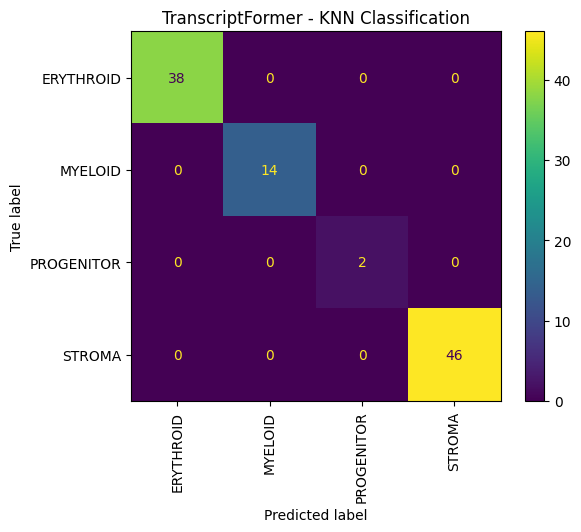

In [9]:
cm_TranscriptFormer = confusion_matrix(X_test.obs['LVL1'],pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_TranscriptFormer, display_labels=np.unique(np.concatenate((X_test.obs['LVL1'], pred_labels))))
disp.plot(xticks_rotation="vertical")
plt.title("TranscriptFormer - KNN Classification")
plt.show()

In [10]:
print(classification_report(X_test.obs['LVL1'],pred_labels))

              precision    recall  f1-score   support

   ERYTHROID       1.00      1.00      1.00        38
     MYELOID       1.00      1.00      1.00        14
  PROGENITOR       1.00      1.00      1.00         2
      STROMA       1.00      1.00      1.00        46

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



## 5) Compare Results - Who's better ?
Now, who is better ? which model should you use for your cell classification task ? Let's put the results next to each other to compare:

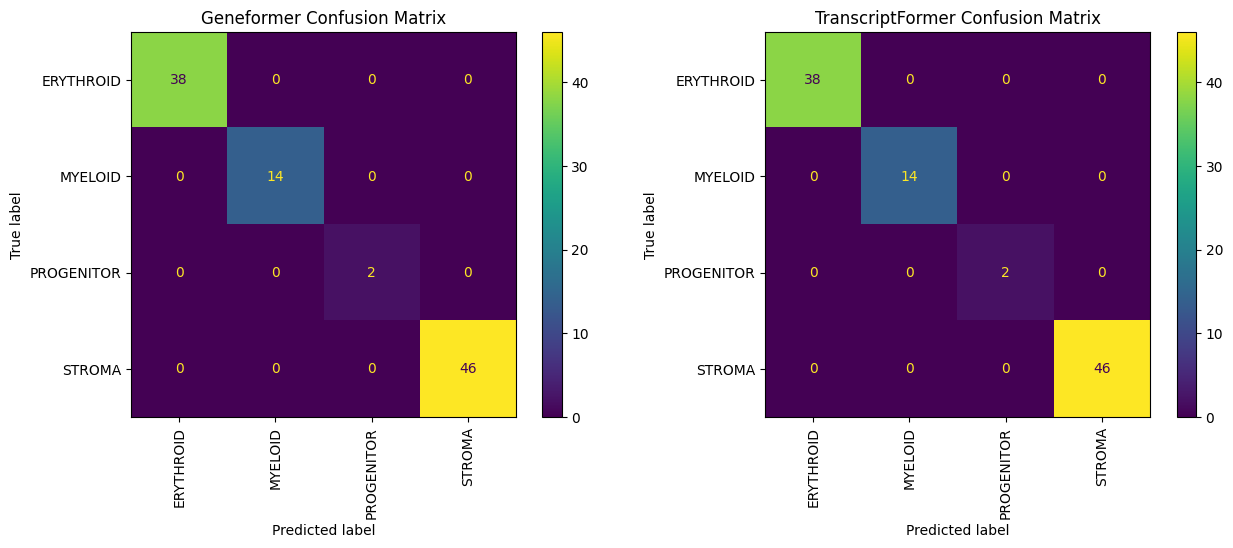

In [20]:
# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_geneformer, display_labels=np.unique(np.concatenate((X_test.obs['LVL1'], pred_labels))))
disp.plot(xticks_rotation="vertical",ax=axs[0])
axs[0].set_title('Geneformer Confusion Matrix')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_TranscriptFormer, display_labels=np.unique(np.concatenate((X_test.obs['LVL1'], pred_labels))))
disp.plot(xticks_rotation="vertical",ax=axs[1])
axs[1].set_title('TranscriptFormer Confusion Matrix')

plt.show()

## What's next ?
Stay tuned, we will add the most relevant RNA foundation models to Helical (and other modalities).

If you have a use case in mind that we should look at, some feedback to share, or you just want to have a chat, please reach out (support@helical-ai.com), we will get back to you really quickly :)